In [1]:
import pandas as pd 
import os
import matplotlib as plt 
import seaborn as snb


In [17]:
df= pd.read_csv (r"C:\Users\yigit\Downloads\archive(33)\creditcard.csv")
print(df.shape)
print(df.columns.tolist()[:10], "…")
print("Fraud rate:", df["Class"].mean())
print(df.head())

(284807, 31)
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9'] …
Fraud rate: 0.001727485630620034
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 

In [19]:
print(df.info())

print("\nMissing values (total):", int(df.isna().sum().sum()))
print("Duplicate rows:", int(df.duplicated().sum()))

counts = df["Class"].value_counts().sort_index()
ratio = counts / counts.sum()
print("\nClass counts:\n", counts)
print("\nClass ratio:\n", ratio)
print("\nFraud rate (%):", round(100*ratio.get(1,0), 4))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [21]:

print("\nAmount overall:")
print(df["Amount"].describe(percentiles=[.5,.9,.99]))

print("\nAmount by class:")
print(df.groupby("Class")["Amount"].describe(percentiles=[.5,.9,.99]))



Amount overall:
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
50%          22.000000
90%         203.000000
99%        1017.970000
max       25691.160000
Name: Amount, dtype: float64

Amount by class:
          count        mean         std  min    50%      90%        99%  \
Class                                                                     
0      284315.0   88.291022  250.105092  0.0  22.00  202.724  1016.9664   
1         492.0  122.211321  256.683288  0.0   9.25  346.746  1357.4279   

            max  
Class            
0      25691.16  
1       2125.87  


In [23]:

back_steps = (df["Time"].diff() < 0).sum()
print("Non-monotonic time steps:", int(back_steps))

df = df.sort_values("Time").reset_index(drop=True)


Non-monotonic time steps: 0


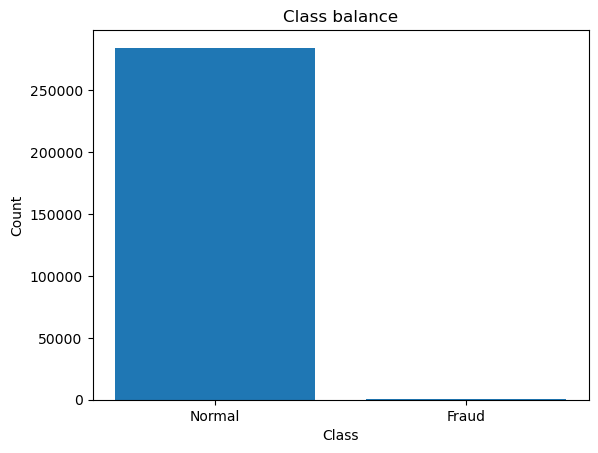

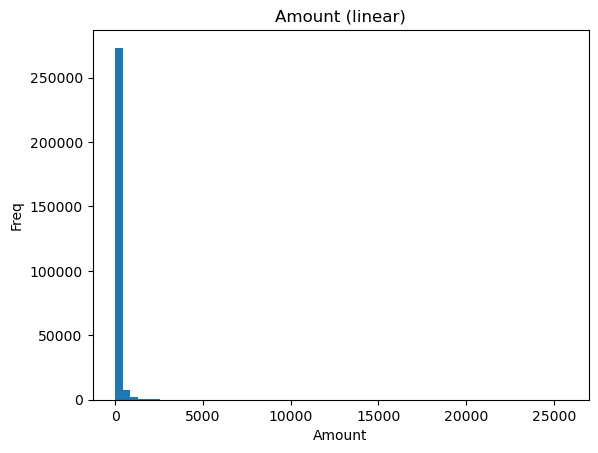

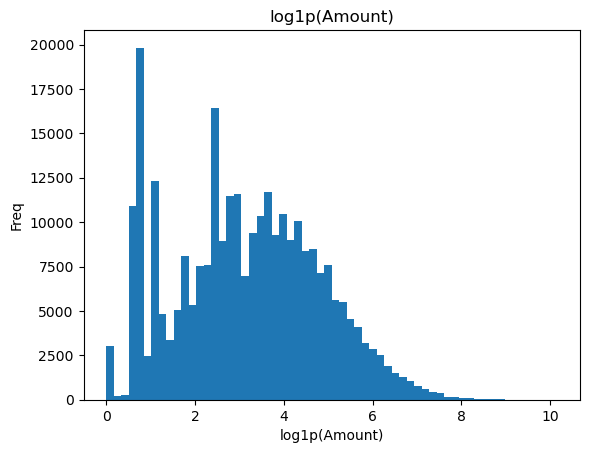

In [27]:
import matplotlib.pyplot as plt
import numpy as np 
fig = plt.figure()
plt.bar(["Normal","Fraud"], [counts.get(0,0), counts.get(1,0)])
plt.title("Class balance")
plt.xlabel("Class"); plt.ylabel("Count")
plt.show()

fig = plt.figure()
plt.hist(df["Amount"], bins=60)
plt.title("Amount (linear)"); plt.xlabel("Amount"); plt.ylabel("Freq")
plt.show()

fig = plt.figure()
plt.hist(np.log1p(df["Amount"]), bins=60)
plt.title("log1p(Amount)"); plt.xlabel("log1p(Amount)"); plt.ylabel("Freq")
plt.show()


In [29]:

df = df.drop_duplicates().reset_index(drop=True)

df = df.sort_values("Time").reset_index(drop=True)

feature_cols = [c for c in df.columns if c.startswith("V")] + ["Amount"]

split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx].copy()
val_df   = df.iloc[split_idx:].copy()

print("Train size:", train_df.shape, "Val size:", val_df.shape)
print("Train fraud rate:", round(train_df['Class'].mean(), 5),
      "| Val fraud rate:", round(val_df['Class'].mean(), 5))


Train size: (226980, 31) Val size: (56746, 31)
Train fraud rate: 0.00176 | Val fraud rate: 0.0013


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


X_train_norm = train_df.loc[train_df["Class"]==0, feature_cols].values
X_val        = val_df[feature_cols].values
y_val        = val_df["Class"].values  

scaler = StandardScaler()
X_train_norm_scaled = scaler.fit_transform(X_train_norm)
X_val_scaled        = scaler.transform(X_val)

iforest = IsolationForest(
    n_estimators=300,
    max_samples=256,
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)
iforest.fit(X_train_norm_scaled)

val_scores = -iforest.score_samples(X_val_scaled)
val_scores[:5]


array([0.37145416, 0.37782903, 0.379405  , 0.40461989, 0.37724689])

In [33]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

percentiles = [99.0, 99.3, 99.5, 99.7, 99.9, 99.95, 99.99]
results = []
for p in percentiles:
    thr = np.percentile(val_scores, p)
    y_hat = (val_scores >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_val, y_hat, average="binary", zero_division=0
    )
    results.append((p, thr, prec, rec, f1))


results_sorted = sorted(results, key=lambda x: x[4], reverse=True)
for p, thr, prec, rec, f1 in results_sorted:
    print(f"p={p:7.2f} | thr={thr:.4f} | precision={prec:.3f} | recall={rec:.3f} | F1={f1:.3f}")

best_p, best_thr, best_prec, best_rec, best_f1 = results_sorted[0]
print("\nChosen threshold:", best_thr, "(percentile:", best_p, ")")
print("AUC (sanity check):", roc_auc_score(y_val, val_scores))


p=  99.00 | thr=0.5714 | precision=0.062 | recall=0.473 | F1=0.109
p=  99.30 | thr=0.5889 | precision=0.055 | recall=0.297 | F1=0.093
p=  99.50 | thr=0.6038 | precision=0.053 | recall=0.203 | F1=0.084
p=  99.70 | thr=0.6213 | precision=0.023 | recall=0.054 | F1=0.033
p=  99.90 | thr=0.6611 | precision=0.000 | recall=0.000 | F1=0.000
p=  99.95 | thr=0.6897 | precision=0.000 | recall=0.000 | F1=0.000
p=  99.99 | thr=0.7347 | precision=0.000 | recall=0.000 | F1=0.000

Chosen threshold: 0.5713941461053634 (percentile: 99.0 )
AUC (sanity check): 0.9497785740992263


In [35]:
import json, os
from joblib import dump

os.makedirs("artifacts", exist_ok=True)
dump(scaler, "artifacts/scaler.joblib")
dump(iforest, "artifacts/iforest.joblib")
with open("artifacts/metadata.json", "w") as f:
    json.dump({
        "feature_cols": feature_cols,
        "threshold": float(best_thr),
        "model": "IsolationForest",
        "version": "1.0.0"
    }, f, indent=2)

print("Saved → artifacts/scaler.joblib, artifacts/iforest.joblib, artifacts/metadata.json")


Saved → artifacts/scaler.joblib, artifacts/iforest.joblib, artifacts/metadata.json


In [37]:
import joblib, json


scaler_l = joblib.load("artifacts/scaler.joblib")
model_l  = joblib.load("artifacts/iforest.joblib")
meta     = json.load(open("artifacts/metadata.json"))
FEATS    = meta["feature_cols"]
THR      = meta["threshold"]

def score_event(event: dict):
    
    x = np.array([event[c] for c in FEATS], dtype=float).reshape(1, -1)
    x = scaler_l.transform(x)
    score = float(-model_l.score_samples(x)[0])  
    return {"score": score, "is_anomaly": bool(score >= THR)}


sample = val_df.iloc[0]
ev = {c: float(sample[c]) for c in FEATS}
score_event(ev)


{'score': 0.3714541599970908, 'is_anomaly': False}

In [39]:
pip install fastapi uvicorn nest_asyncio requests


   ---------------------------------------- 0.0/95.6 kB ? eta -:--:--
   ------------ --------------------------- 30.7/95.6 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 95.6/95.6 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/66.4 kB ? eta -:--:--
   ---------------------------------------- 66.4/66.4 kB ? eta 0:00:00
   ---------------------------------------- 0.0/73.0 kB ? eta -:--:--
   ---------------------------------------- 73.0/73.0 kB 4.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [43]:
# Rebuild the app quickly (safe to re-run)
import json, joblib, numpy as np
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import Dict, Optional

meta     = json.load(open("artifacts/metadata.json"))
FEATURES = meta["feature_cols"]
THRESH   = meta["threshold"]
scaler   = joblib.load("artifacts/scaler.joblib")
model    = joblib.load("artifacts/iforest.joblib")

class ScoreRequest(BaseModel):
    ts: Optional[float] = None
    features: Dict[str, float]

app = FastAPI(title="Anomaly Scoring API", version=meta.get("version","1.0.0"))

def score_vector(feat_dict: Dict[str, float]) -> float:
    missing = [f for f in FEATURES if f not in feat_dict]
    if missing:
        raise HTTPException(status_code=400, detail={"error":"Missing features","missing":missing})
    x = np.array([feat_dict[f] for f in FEATURES], dtype=float).reshape(1, -1)
    x = scaler.transform(x)
    return float(-model.score_samples(x)[0])  # higher = more anomalous

@app.get("/healthz")
def healthz(): return {"ok": True}

@app.post("/score")
def score(req: ScoreRequest):
    s = score_vector(req.features)
    return {"score": s, "is_anomaly": bool(s >= THRESH)}

# --- run in a background thread so the notebook stays free ---
import threading, uvicorn, nest_asyncio
nest_asyncio.apply()

def _run(): uvicorn.run(app, host="127.0.0.1", port=8000, log_level="info")
api_thread = threading.Thread(target=_run, daemon=True)
api_thread.start()
print("API started on http://127.0.0.1:8000  (stop by restarting kernel)")
 


API started on http://127.0.0.1:8000  (stop by restarting kernel)


In [45]:
import requests
row = val_df.iloc[0]  # from your earlier split
payload = {"ts": float(row["Time"]), "features": {k: float(row[k]) for k in FEATURES}}
print(requests.get("http://127.0.0.1:8000/healthz").json())
print(requests.post("http://127.0.0.1:8000/score", json=payload).json())


INFO:     127.0.0.1:52562 - "GET /healthz HTTP/1.1" 200 OK
{'ok': True}
INFO:     127.0.0.1:52563 - "POST /score HTTP/1.1" 200 OK
{'score': 0.3714541599970908, 'is_anomaly': False}


In [ ]:
!pip install duckdb -q
import duckdb, os
os.makedirs("storage", exist_ok=True)
con = duckdb.connect("storage/anomaly_demo.duckdb")
con.execute("""CREATE TABLE IF NOT EXISTS events_clean (event_id BIGINT, ts DOUBLE, amount DOUBLE);""")
con.execute("""CREATE TABLE IF NOT EXISTS predictions (event_id BIGINT, ts DOUBLE, score DOUBLE, is_anomaly BOOLEAN, label INTEGER);""")
con.close()


In [1]:
import pandas as pd

CSV_PATH = r"C:\Users\yigit\Downloads\archive(33)\creditcard.csv"  # change if needed
df = pd.read_csv(CSV_PATH).drop_duplicates().sort_values("Time").reset_index(drop=True)

feature_cols = [c for c in df.columns if c.startswith("V")] + ["Amount"]
split_idx = int(0.8 * len(df))
val_df = df.iloc[split_idx:].copy()
len(val_df), val_df.head(2)


(56746,
             Time        V1        V2        V3        V4        V5        V6  \
 226980  145234.0  0.142992  1.065405 -0.407432 -0.562355  1.001791 -0.726233   
 226981  145234.0  2.090479 -0.421305 -1.131660 -0.376639 -0.437267 -1.209900   
 
               V7        V8        V9  ...       V21       V22       V23  \
 226980  0.987183 -0.108879 -0.115908  ... -0.333582 -0.779618  0.089250   
 226981 -0.057589 -0.320474  1.262884  ...  0.045960  0.467391  0.076309   
 
              V24       V25       V26       V27       V28  Amount  Class  
 226980  0.512207 -0.416654  0.117893  0.228984  0.084345    1.79      0  
 226981  0.153868  0.025768  0.999199 -0.086959 -0.075485    1.00      0  
 
 [2 rows x 31 columns])

In [3]:
import json, joblib, numpy as np
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import Dict, Optional
import threading, uvicorn, nest_asyncio

meta     = json.load(open("artifacts/metadata.json"))
FEATURES = meta["feature_cols"]
THRESH   = meta["threshold"]
scaler   = joblib.load("artifacts/scaler.joblib")
model    = joblib.load("artifacts/iforest.joblib")

class ScoreRequest(BaseModel):
    ts: Optional[float] = None
    features: Dict[str, float]

app = FastAPI(title="Anomaly Scoring API", version=meta.get("version","1.0.0"))

def score_vector(feat_dict: Dict[str, float]) -> float:
    missing = [f for f in FEATURES if f not in feat_dict]
    if missing:
        raise HTTPException(status_code=400, detail={"error":"Missing features","missing":missing})
    x = np.array([feat_dict[f] for f in FEATURES], dtype=float).reshape(1, -1)
    x = scaler.transform(x)
    return float(-model.score_samples(x)[0])  # higher = more anomalous

@app.get("/healthz")
def healthz(): return {"ok": True}

@app.post("/score")
def score(req: ScoreRequest):
    s = score_vector(req.features)
    return {"score": s, "is_anomaly": bool(s >= THRESH)}

nest_asyncio.apply()
def _run(): uvicorn.run(app, host="127.0.0.1", port=8000, log_level="error")
api_thread = threading.Thread(target=_run, daemon=True)
api_thread.start()
print("API started on http://127.0.0.1:8000")


API started on http://127.0.0.1:8000


In [5]:
import requests
row = val_df.iloc[0]
payload = {"ts": float(row["Time"]), "features": {k: float(row[k]) for k in FEATURES}}
print(requests.get("http://127.0.0.1:8000/healthz", timeout=3).json())
print(requests.post("http://127.0.0.1:8000/score", json=payload, timeout=5).json())


{'ok': True}
{'score': 0.3714541599970908, 'is_anomaly': False}


In [7]:
import sqlite3, os
os.makedirs("storage", exist_ok=True)
DB_PATH = "storage/anomaly_demo.sqlite"

conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()
cur.execute("""CREATE TABLE IF NOT EXISTS events_clean (
  event_id INTEGER, ts REAL, amount REAL
);""")
cur.execute("""CREATE TABLE IF NOT EXISTS predictions (
  event_id INTEGER, ts REAL, score REAL, is_anomaly INTEGER, label INTEGER
);""")
conn.commit(); conn.close()
print("SQLite ready at", DB_PATH)


SQLite ready at storage/anomaly_demo.sqlite


In [9]:
import time, requests, sqlite3

API_URL = "http://127.0.0.1:8000/score"
DB_PATH = "storage/anomaly_demo.sqlite"

def stream_and_score_sqlite(df, limit=3000, speedup=3000, max_sleep=0.03):
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()
    prev_ts = float(df["Time"].iloc[0])

    for sent, (idx, row) in enumerate(df.iterrows()):
        payload = {"ts": float(row["Time"]), "features": {k: float(row[k]) for k in FEATURES}}
        r = requests.post(API_URL, json=payload, timeout=5); r.raise_for_status()
        res = r.json()

        cur.execute("INSERT INTO events_clean VALUES (?, ?, ?)",
                    (int(idx), float(row["Time"]), float(row["Amount"])))
        cur.execute("INSERT INTO predictions VALUES (?, ?, ?, ?, ?)",
                    (int(idx), float(row["Time"]), float(res["score"]),
                     int(bool(res["is_anomaly"])), int(row["Class"])))

        if sent % 250 == 0:
            conn.commit()
            print(f"sent={sent}, ts={row['Time']:.1f}, score={res['score']:.3f}, anomaly={res['is_anomaly']}")

        delay = max((float(row["Time"]) - prev_ts)/speedup, 0.0)
        time.sleep(min(delay, max_sleep))
        prev_ts = float(row["Time"])
        if limit and (sent + 1) >= limit: break

    conn.commit(); conn.close()
    print("Done streaming.")

stream_and_score_sqlite(val_df)


sent=0, ts=145234.0, score=0.371, anomaly=False
sent=250, ts=145346.0, score=0.382, anomaly=False
sent=500, ts=145461.0, score=0.372, anomaly=False
sent=750, ts=145571.0, score=0.590, anomaly=True
sent=1000, ts=145679.0, score=0.396, anomaly=False
sent=1250, ts=145790.0, score=0.368, anomaly=False
sent=1500, ts=145880.0, score=0.405, anomaly=False
sent=1750, ts=145977.0, score=0.383, anomaly=False
sent=2000, ts=146070.0, score=0.396, anomaly=False
sent=2250, ts=146179.0, score=0.381, anomaly=False
sent=2500, ts=146288.0, score=0.411, anomaly=False
sent=2750, ts=146394.0, score=0.438, anomaly=False
Done streaming.


In [11]:
        import pandas as pd, sqlite3
conn = sqlite3.connect(DB_PATH)
print(pd.read_sql_query("SELECT COUNT(*) AS n, SUM(is_anomaly) AS anomalies FROM predictions;", conn))
display(pd.read_sql_query("SELECT * FROM predictions ORDER BY ts DESC LIMIT 5;", conn))
conn.close()


      n  anomalies
0  3000         55


,event_id,ts,score,is_anomaly,label
0,229978,146500.0,0.420971,0,0
1,229979,146500.0,0.371183,0,0
2,229975,146499.0,0.387090,0,0
3,229976,146499.0,0.434670,0,0
4,229977,146499.0,0.392125,0,0


In [13]:
pip install streamlit streamlit-autorefresh


   ---------------------------------------- 0.0/700.8 kB ? eta -:--:--
    --------------------------------------- 10.2/700.8 kB ? eta -:--:--
   - ------------------------------------- 30.7/700.8 kB 262.6 kB/s eta 0:00:03
   --- ----------------------------------- 71.7/700.8 kB 491.5 kB/s eta 0:00:02
   --------------------- ------------------ 368.6/700.8 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 700.8/700.8 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [15]:

path = r"C:\Users\yigit\dashboard.py"
code = r'''
import sqlite3
import pandas as pd
import streamlit as st
from streamlit_autorefresh import st_autorefresh

# Use your absolute DB path for safety
DB_PATH = r"C:\Users\yigit\storage\anomaly_demo.sqlite"

st.set_page_config(page_title="Real-Time Anomaly Dashboard", layout="wide")
st.title("Real-Time Anomaly Detection — Live Dashboard")

# Auto-refresh every 2 seconds
st_autorefresh(interval=2000, key="refresh")

@st.cache_resource
def get_conn():
    return sqlite3.connect(DB_PATH, check_same_thread=False)

def load_predictions(limit=20000):
    try:
        conn = get_conn()
        df = pd.read_sql_query(
            "SELECT event_id, ts, score, is_anomaly, label "
            "FROM predictions ORDER BY ts DESC LIMIT ?;",
            conn, params=[limit]
        )
        if not df.empty:
            df["is_anomaly"] = df["is_anomaly"].astype(int)
            df["label"] = df["label"].astype(int)
        return df
    except Exception as e:
        st.error(f"Could not read DB at {DB_PATH}: {e}")
        return pd.DataFrame(columns=["event_id","ts","score","is_anomaly","label"])

df = load_predictions()

# ---- KPIs ----
total = len(df)
anoms = int(df["is_anomaly"].sum()) if total else 0
rate  = (anoms / total * 100) if total else 0.0
tp = int(((df["is_anomaly"]==1) & (df["label"]==1)).sum()) if total else 0
pred_pos = anoms
precision = (tp / pred_pos * 100) if pred_pos else 0.0

c1, c2, c3, c4 = st.columns(4)
c1.metric("Rows scored (loaded)", f"{total:,}")
c2.metric("Anomalies flagged", f"{anoms:,}")
c3.metric("Anomaly rate", f"{rate:.2f}%")
c4.metric("Precision (labels in stream)", f"{precision:.1f}%")

# ---- Trend chart (per-minute bins) ----
if total:
    df_m = df.copy()
    df_m["minute"] = (df_m["ts"] // 60).astype(int)
    base = int(df_m["minute"].min())
    df_m["t"] = df_m["minute"] - base  # minutes since stream start

    agg = df_m.groupby("t", as_index=False).agg(
        rows=("event_id","count"),
        anomalies=("is_anomaly","sum"),
        frauds=("label","sum")
    ).sort_values("t")

    st.subheader("Anomalies per minute")
    st.line_chart(agg.set_index("t")[["anomalies", "frauds"]])

    st.subheader("Most recent anomalies")
    k = st.slider("Rows to show", 10, 200, 50)
    recent = df[df["is_anomaly"]==1].head(k)
    st.dataframe(recent, use_container_width=True)

    st.subheader("Top 50 by anomaly score")
    top = df.sort_values("score", ascending=False).head(50)
    st.dataframe(top, use_container_width=True)
else:
    st.info("No predictions found yet. Run the streaming cell in your notebook to populate the database.")
'''
open(path, "w", encoding="utf-8").write(code)
print("Wrote clean dashboard to:", path)


Wrote clean dashboard to: C:\Users\yigit\dashboard.py


In [17]:

path = r"C:\Users\yigit\dashboard.py"
code = r'''
import os, time, threading, json, sqlite3
import pandas as pd
import requests
import streamlit as st

# optional auto-refresh plugin
try:
    from streamlit_autorefresh import st_autorefresh
    AUTO = True
except Exception:
    AUTO = False

DB_PATH = r"C:\Users\yigit\storage\anomaly_demo.sqlite"          # <-- your DB
ART_META = r"C:\Users\yigit\artifacts\metadata.json"             # <-- to read saved threshold (if exists)

st.set_page_config(page_title="Real-Time Anomaly Dashboard", layout="wide")
st.title("Real-Time Anomaly Detection — Live Dashboard")
if AUTO: st_autorefresh(interval=2000, key="refresh")
else:    st.caption("Tip: auto-refresh plugin not installed. Install later:  pip install streamlit-autorefresh")

@st.cache_resource
def get_conn():
    return sqlite3.connect(DB_PATH, check_same_thread=False)

def load_predictions(limit=30000):
    conn = get_conn()
    df = pd.read_sql_query(
        "SELECT event_id, ts, score, is_anomaly, label FROM predictions ORDER BY ts DESC LIMIT ?;",
        conn, params=[limit]
    )
    if not df.empty:
        df["is_anomaly"] = df["is_anomaly"].astype(int)
        df["label"]      = df["label"].astype(int)
    return df

# ---------------- Sidebar controls ----------------
st.sidebar.header("Controls")

API_URL = st.sidebar.text_input("Scoring API URL", "http://127.0.0.1:8000/score")
CSV_PATH = st.sidebar.text_input("CSV path to stream",
    r"C:\Users\yigit\Downloads\archive(33)\creditcard.csv")

limit    = int(st.sidebar.number_input("Rows to stream per click", 100, 50000, 3000, step=100))
speedup  = int(st.sidebar.number_input("Time speedup (higher=faster)", 100, 20000, 3000, step=100))
max_sleep= float(st.sidebar.number_input("Max sleep per row (sec)", 0.0, 1.0, 0.03, step=0.01, format="%.2f"))

if "streaming" not in st.session_state: st.session_state.streaming = False
if "stream_thread" not in st.session_state: st.session_state.stream_thread = None

def stream_worker(csv_path, api_url, limit, speedup, max_sleep):
    # load & normalize CSV exactly like training did
    df = pd.read_csv(csv_path).drop_duplicates().sort_values("Time").reset_index(drop=True)
    feats = [c for c in df.columns if c.startswith("V")] + ["Amount"]

    conn = get_conn()
    cur  = conn.cursor()
    # resume from last event_id if present
    try:
        last = pd.read_sql_query("SELECT MAX(event_id) AS m FROM predictions;", conn)["m"].iloc[0]
        start_idx = 0 if pd.isna(last) else int(last) + 1
    except Exception:
        start_idx = 0

    if start_idx >= len(df): return
    prev_ts = float(df.at[start_idx, "Time"])
    sent = 0

    for idx in range(start_idx, min(start_idx + limit, len(df))):
        if not st.session_state.streaming:
            break
        row = df.iloc[idx]
        payload = {"ts": float(row["Time"]),
                   "features": {k: float(row[k]) for k in feats}}
        try:
            r = requests.post(api_url, json=payload, timeout=5)
            r.raise_for_status()
            res = r.json()  # {'score':..., 'is_anomaly':...}
        except Exception as e:
            st.session_state.streaming = False
            st.toast(f"Streaming stopped: {e}", icon="⚠️")
            break

        cur.execute("INSERT INTO events_clean VALUES (?, ?, ?)",
                    (int(idx), float(row["Time"]), float(row["Amount"])))
        cur.execute("INSERT INTO predictions VALUES (?, ?, ?, ?, ?)",
                    (int(idx), float(row["Time"]), float(res["score"]),
                     int(bool(res["is_anomaly"])), int(row.get("Class", 0))))
        if sent % 200 == 0: conn.commit()

        delay = max((float(row["Time"]) - prev_ts) / speedup, 0.0)
        time.sleep(min(delay, max_sleep))
        prev_ts = float(row["Time"])
        sent += 1

    conn.commit()
    st.toast(f"Streamed {sent} rows.", icon="✅")

cols = st.sidebar.columns(2)
if cols[0].button("Start streaming", disabled=st.session_state.streaming):
    if not os.path.exists(CSV_PATH):
        st.sidebar.error(f"CSV not found: {CSV_PATH}")
    else:
        # quick health check
        try:
            requests.get(API_URL.replace("/score","/healthz"), timeout=3)
        except Exception as e:
            st.sidebar.error(f"API not reachable at {API_URL}: {e}")
        else:
            st.session_state.streaming = True
            st.session_state.stream_thread = threading.Thread(
                target=stream_worker,
                args=(CSV_PATH, API_URL, limit, speedup, max_sleep),
                daemon=True
            )
            st.session_state.stream_thread.start()
            st.sidebar.success("Streaming started…")

if cols[1].button("Stop", type="secondary", disabled=not st.session_state.streaming):
    st.session_state.streaming = False
    st.sidebar.info("Stop requested.")

# ---- Load data & UI threshold ----
df = load_predictions()

# default threshold = saved from training if available, else 99th percentile of scores
def default_threshold(scores: pd.Series) -> float:
    if os.path.exists(ART_META):
        try:
            return float(json.load(open(ART_META))["threshold"])
        except Exception:
            pass
    return float(scores.quantile(0.99)) if len(scores) else 0.5

if len(df):
    thr_default = default_threshold(df["score"])
    min_thr = float(df["score"].quantile(0.95))
    max_thr = float(df["score"].quantile(0.999))
    thr_ui = st.sidebar.slider("Display threshold (re-flag by score)",
                               min_value=min_thr, max_value=max_thr, value=thr_default)
    df["flag_ui"] = (df["score"] >= thr_ui).astype(int)
else:
    thr_ui = 0.5
    df["flag_ui"] = 0

# ---- KPIs (using UI threshold) ----
total = len(df)
pred_pos = int(df["flag_ui"].sum()) if total else 0
tp = int(((df["flag_ui"]==1) & (df["label"]==1)).sum()) if total else 0
precision = (tp / pred_pos * 100) if pred_pos else 0.0
rate = (pred_pos / total * 100) if total else 0.0

c1, c2, c3, c4 = st.columns(4)
c1.metric("Rows scored (loaded)", f"{total:,}")
c2.metric("Anomalies flagged (UI)", f"{pred_pos:,}")
c3.metric("Anomaly rate", f"{rate:.2f}%")
c4.metric("Precision (labels in stream)", f"{precision:.1f}%")

# ---- Trend chart ----
if total:
    df_m = df.copy()
    df_m["minute"] = (df_m["ts"] // 60).astype(int)
    base = int(df_m["minute"].min())
    df_m["t"] = df_m["minute"] - base

    agg = df_m.groupby("t", as_index=False).agg(
        rows=("event_id","count"),
        anomalies=("flag_ui","sum"),
        frauds=("label","sum")
    ).sort_values("t")

    st.subheader("Anomalies per minute (UI threshold)")
    st.line_chart(agg.set_index("t")[["anomalies", "frauds"]])

    st.subheader("Most recent anomalies")
    k = st.slider("Rows to show", 10, 200, 50)
    recent = df[df["flag_ui"]==1].head(k)
    st.dataframe(recent[["event_id","ts","score","flag_ui","label"]], use_container_width=True)

    st.subheader("Top 50 by anomaly score")
    top = df.sort_values("score", ascending=False).head(50)
    st.dataframe(top[["event_id","ts","score","flag_ui","label"]], use_container_width=True)
else:
    st.info("No predictions yet. Use **Start streaming** in the sidebar.")
'''
open(path, "w", encoding="utf-8").write(code)
print("Dashboard updated:", path)


Dashboard updated: C:\Users\yigit\dashboard.py
